---
# Préparation des Données

---

Pour préparer adéquatement les données avant de les fournir à un ou plusieurs algorithmes d'apprentissage automatique, il faut également s'assurer de la bonne représentation de ces données pour ne pas leur fournir de valeurs trop différentes qu'ils ne pourraient manipuler conjointement.

<center><img src="./img/mlprocess_2.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

1. Le nettoyage et les aberrations statistiques.
2. L'imputation de données manquantes.
3. Équilibrage de données déséquilibrées.
4. Transformation des données
    1. *rescaling* et *normalizing* (\[0, 1\] ou \[-1, 1\]), *standardizing* (loi normale).
    2. Traitement des variables catégoriques.
5. **Réduction de la dimensionnalité ou création de caractéristiques**
    1. Réduction de la dimensionnalité
    2. Déroulement ou aplatissement d'une surface 3D en 2D



## 5. Réduction de la dimensionnalité ou création de caractéristiques

### Réduction de la dimensionnalité

Séquence inspirée des exemples de code de la librairie Scikit-Learn de [Fabian Pedregosa](mailto:fabian.pedregosa@inria.fr), 
[Olivier Grisel](mailto:olivier.grisel@ensta.org), [Mathieu Blondel](mailto:mathieu@mblondel.org) et Gael Varoquaux (License: BSD 3 clause)

La réduction de la dimensionnalité consiste à prendre des données dans un espace de grande dimension, et à les 
transformer en données dans un espace de plus petite dimension. Le défi consiste à conserver le maximum d’information 
partagée entre les données lors de la transformation. Ainsi, les données en sortie, plus petites, pourront 
être traitées plus rapidement avec nos algorithmes d’analyse et de traîtement. 

Plusieurs méthodes sont présentées dans ce qui suit. Les méthodes linéaires sont présentées en premier. 
Les méthodes non-linéaires suivent ensuite. Elles donnent généralement de
meilleurs résultats que les premières, mais sont plus gourmandes en mémoire et temps de calcul.


In [1]:
# Import des librairies nécessaires

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn.utils import check_random_state
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.decomposition import FastICA

Axes3D

Automatically created module for IPython interactive environment


mpl_toolkits.mplot3d.axes3d.Axes3D

Le code ci-dessous sert à afficher les graphiques joliment.

In [2]:
# Lecture de la base de données Digits en ne sélectionnant que les images des classes 0 à 5.
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30
n_components = 2

# Fonction pour afficher la projection
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1((y[i]+1) / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

#### Exemples de données

Nous allons utiliser un sous-ensemble de la base de données MNIST qui comprend des images de chiffres 0 à 9 de taille 8x8. 
On peut considérer qu'à chaque image correspond un point dans un espace de dimension 8*8=64. Il est évidemment 
impossible de visualiser la distribution des images sous cette forme. On peut toutefois réduire la dimensionnalité 
de l'espace afin de le projeter dans un sous-espace de dimension 2, nettement plus pratique! Il existe de nombreuses 
méthodes de projection produisant des résultats souvent très différents. Nous allons en décrire plusieurs.


Text(0.5, 1.0, 'Une sélection des 6 premiers chiffres de la base de données MNIST')

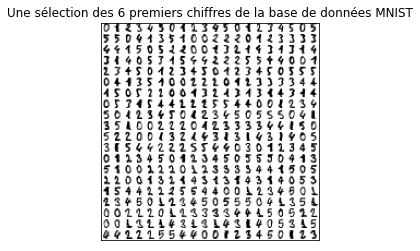

In [3]:
# Affichons quelques images de chiffres pour l'exemple
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('Une sélection des 6 premiers chiffres de la base de données MNIST')

#### Projection aléatoire

Cette méthode effectue une projection des chiffres au moyen d'une matrice sparse aléatoire. Les résultats 
ne sont pas particulièrement convaincants dans ce cas-ci; il y a un grand recouvrement de chaque classe de chiffres. 

Wall time: 238 ms


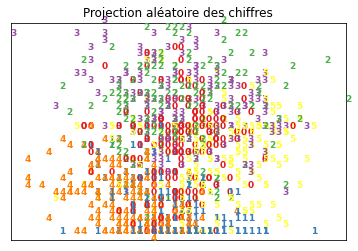

In [4]:
%%time
rp = random_projection.SparseRandomProjection(n_components=n_components, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Projection aléatoire des chiffres")

#### Analyse en composantes principales (PCA)

Cette méthode linéaire classique projette les chiffres sur les deux premiers axes principaux de la matrice de 
covariance des chiffres. Les valeurs projetées en x et en y sont décorrélées. La séparation 
des classes de chiffres est meilleure.

Wall time: 310 ms


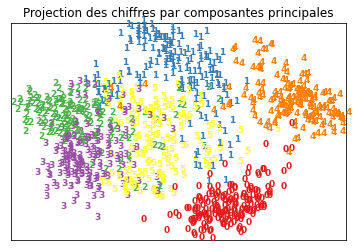

In [5]:
%%time
X_pca = decomposition.PCA(n_components=n_components).fit_transform(X)
plot_embedding(X_pca, "Projection des chiffres par composantes principales")

#### PCA pour données sparses (Latent Semantic Analysis)

Cette méthode linéaire projette les chiffres sur les deux principaux composants LSA (latent semantic analysis). 
C'est une méthode efficace pour faire de la PCA sur des données sparses. Pour cette raison, elle est très utilisée pour
extraire des similarités entre documents. Elle regroupe bien les chiffres d'une même classe, mais les classes 
se superposent plus que dans le cas précédent.


Wall time: 327 ms


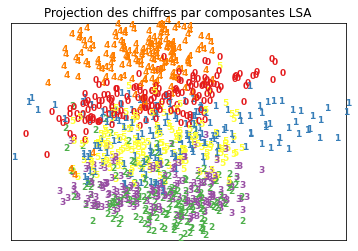

In [6]:
%%time
X_pca = decomposition.TruncatedSVD(n_components=n_components).fit_transform(X)
plot_embedding(X_pca, "Projection des chiffres par composantes LSA")

#### Analyse en composantes indépendantes (ICA)

Cette autre méthode linéaire, similaire à la PCA, projette les chiffres dans un espace où les nouvelles
valeurs en x et en y sont indépendantes. L'indépendance entre des variables est une contrainte plus forte que leur
décorrélation. Les clusters observés sont légèrement mieux séparés qu'avec la PCA.

Wall time: 332 ms


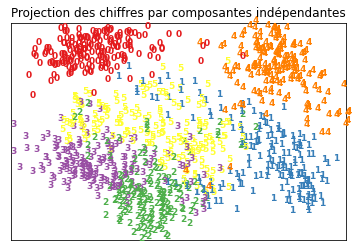

In [7]:
%%time
X_ica = decomposition.FastICA(n_components=n_components).fit_transform(X)
plot_embedding(X_ica, "Projection des chiffres par composantes indépendantes")

#### Analyse par discriminants linéaires (LDA)

Cette méthode linéaire projette les chiffres au moyen des deux principaux discriminants linéaires. Elle performe mieux 
que la PCA lorsqu'il y a beaucoup de données, autrement la PCA est à privilégier.

N.B. La PCA n'utilise que les positions des données et non leurs étiquettes. La LDA utilise les deux sources d'information.

Wall time: 310 ms


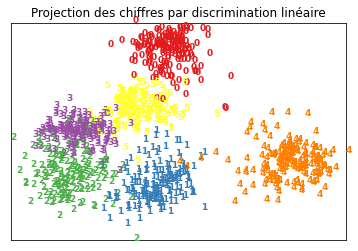

In [8]:
%%time
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # X doit être inversable ... 
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=n_components).fit_transform(X2, y)
plot_embedding(X_lda, "Projection des chiffres par discrimination linéaire")

#### Isomap

Cette méthode et les suivantes sont toutes non-linéaires.

C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 1.06 s


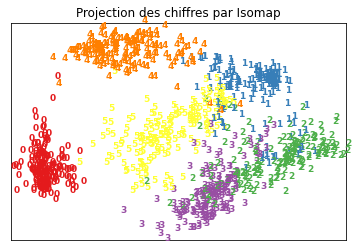

In [9]:
%%time
X_iso = manifold.Isomap(n_neighbors, n_components=n_components).fit_transform(X)
plot_embedding(X_iso, "Projection des chiffres par Isomap")

#### Encodage localement linéaire (LLE)

N.B. Une méthode localement linéaire est globalement non-linéaire.

C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 627 ms


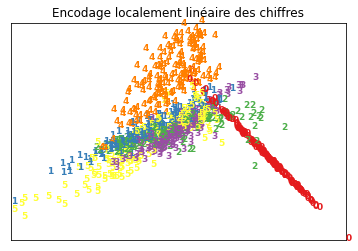

In [10]:
%%time
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=n_components, method='standard')
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "Encodage localement linéaire des chiffres")

#### Alignement des tangentes locales (LSTA)

Les résultats suivants ne sont pas facilement interprétables.

C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 876 ms


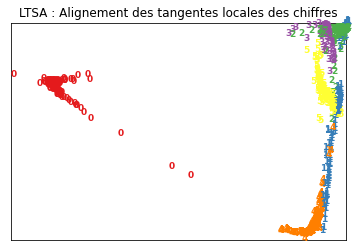

In [11]:
%%time
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=n_components, method='ltsa')
X_ltsa = clf.fit_transform(X)
plot_embedding(X_ltsa,
               "LTSA : Alignement des tangentes locales des chiffres")

#### Multidimensional Scaling (MDS)

Encodage des chiffres par échelonnage multidimensionnel métrique. Les classes sont assez bien séparées, 
mais ont une grande dispersion interne. 

Wall time: 3.85 s


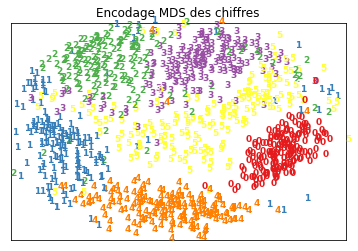

In [12]:
%%time
clf = manifold.MDS(n_components=n_components, n_init=1, max_iter=100)
X_mds = clf.fit_transform(X)
plot_embedding(X_mds, "Encodage MDS des chiffres")

#### Forêt d'isolation

La méthode regroupe bien les chiffres d'une même classe, mais les classes se superposent considérablement, ce 
qui réduit la pertinence du résultat.

Wall time: 517 ms


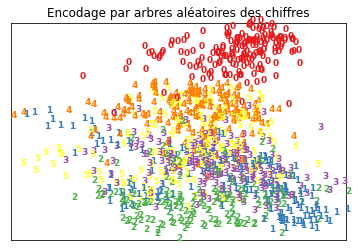

In [13]:
%%time
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=n_components)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Encodage par arbres aléatoires des chiffres")

#### Encodage spectral

Les résultats suivants ne sont pas facilement interprétables, bien que les chiffres soient relativement bien séparés.

Wall time: 470 ms


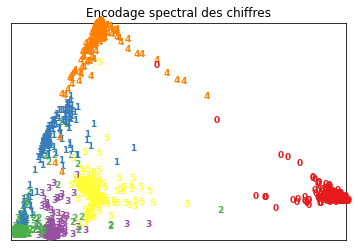

In [14]:
%%time
embedder = manifold.SpectralEmbedding(n_components=n_components, random_state=0, eigen_solver="arpack")
X_se = embedder.fit_transform(X)

plot_embedding(X_se,"Encodage spectral des chiffres")

#### T-Distributed Stochastic Neighbor Embedding (t-SNE)

Ze best one! C'est probablement, et pour de bonnes raisons, la méthode la plus populaire en ce moment 
puisqu'elle permet une excellente séparation des éléments de chaque classe. La séparation
est rarement parfaite, mais elle est souvent meilleure que celles obtenues avec les autres méthodes.  

Wall time: 4.04 s


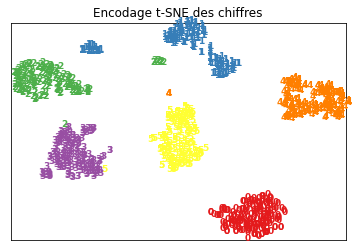

In [15]:
%%time
# Visualizing : https://github.com/oreillymedia/t-SNE-tutorial
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,"Encodage t-SNE des chiffres")

### Déroulement ou aplatissement d'une surface 3D en 2D

Une application intéressante et plutôt terre-à-terre de la réduction de la dimensionalité est le déroulement 
d'une surface 3D arbitrairement complexe sur un plan, par exemple sur une table. On est loin des plongements 
(embeddings) qui visent à transformer des données vers un espace de plus petite dimension afin d'en faciliter 
la classification. Le déroulement permet entre autre d'étudier la topologie puisque ça correspond à déformer une surface, 
idéalement sans la déchirer.

Nous allons en voir quelques exemples.La séquence suivante est inspirée des exemples de code de la librairie Scikit-Learn de 
[Jake Vanderplas](mailto:vanderplas@astro.washington.edu) et 
Jaques Grobler (mailto:jaques.grobler@inria.fr) (License: BSD 3 clause).


Le code ci-dessous sert à afficher les graphiques joliment.

In [16]:
def DerouleSurface3D(X, colors, n_neighbors):
    
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Déroulement de surface avec %i points, %i voisins"
                 % (X.shape[0], n_neighbors), fontsize=14)

    # Affiche la surface 3D de départ
    ax = fig.add_subplot(231, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    # Méthodes de réduction de dimensionalité utilisées pour effectuer le déroulement de la surface sur un plan.
    n_components = 2 # Résultat final en 2D
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')

    methods = OrderedDict()
    methods['Encodage localement linéaire'] = LLE(method='standard')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    methods['Encodage spectral'] = manifold.SpectralEmbedding(n_components=n_components,
                                               n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)

    # Affiche le résultat du déroulement pour chaque méthode
    for i, (label, method) in enumerate(methods.items()):
        t0 = time()
        Y = method.fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))
        ax = fig.add_subplot(2, 3, 2 + i)
        ax.scatter(Y[:, 0], Y[:, 1], c=colors, cmap=plt.cm.Spectral)
        ax.set_title("%s" % (label))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()

#### Déroulement d'un ruban en forme de S

On essaie de dérouler une bande rectangulaire. La figure suivante et les suivantes montrent les résultats obtenus en 
utilisant cinq des méthodes abordées dans la première section. Le premier panneau montre la surface de départ et 
les autres montrent les résultats du déroulement. Le code de couleur identifie les points voisins avant et après 
chaque transformation. Un bon déroulement de la surface devrait conserver l'agencement local des couleurs.

La figure correspond au cas le plus simple que nous allons aborder. Les méthodes Isomap et t-SNE produisent 
les résultats les plus réalistes. Notez que l'orientation du résultat est assez arbitraire. Dans les deux cas, 
un message écrit sur la bande en S serait encore bien lisible sur l'image résultante.  

C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Encodage localement linéaire: 0.071 sec
Isomap: 0.37 sec
MDS: 2.6 sec
Encodage spectral: 0.052 sec
t-SNE: 3.6 sec


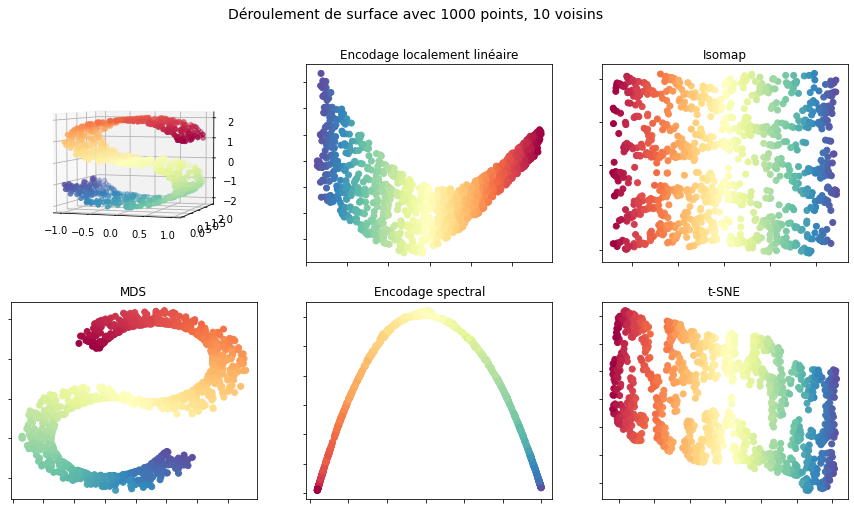

In [17]:
n_points = 1000
n_voisins = 10

# Génération de la surface en S
X, couleurs = datasets.make_s_curve(n_points, random_state=0)

DerouleSurface3D(X, couleurs, n_voisins)

#### Déroulement d'un rouleau suisse

L'exemple suivant est légèrement plus difficile, car la surface s'enroule sur elle-même. Les méthodes d'encodage localement 
linéaire et Isomap produisent les meilleurs résultats. Notez que la méthode t-SNE déchire la bande en plusieurs sections.

Cet exemple n'est pas trivial, car on lui a trouvé une belle application en archéologie. On s'en sert pour dérouler des
rouleaux de papyrus carbonisés! Un grand nombre d'entre eux ont été trouvés dans une bibliothèque de la ville 
d'Herculanum détruite par l'éruption du Vésuve en 79 AD. Ils ont été imagés dans un scanner CT et on peut voir 
l'encre disposée en rouleau suisse dans sa matrice de carbone! On peut ainsi lire un papyrus carbonisé il y a près de 2000 ans.


C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Encodage localement linéaire: 0.075 sec
Isomap: 0.38 sec
MDS: 2.9 sec
Encodage spectral: 0.047 sec
t-SNE: 3.6 sec


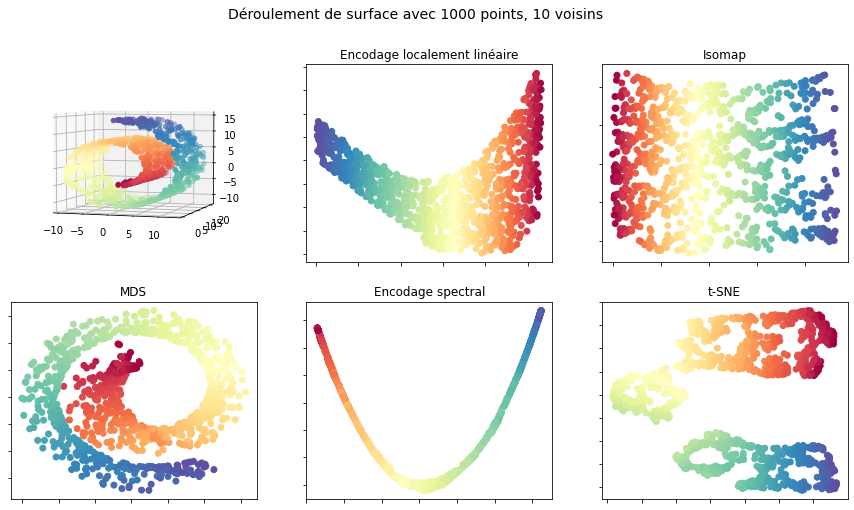

In [18]:
n_points = 1000
n_voisins = 10

# Génération du rouleau suisse
X, couleurs = datasets.make_swiss_roll(n_points)

DerouleSurface3D(X, couleurs, n_voisins)

#### Déroulement d'un hémisphère

À première vue, cette surface 3D semble plus difficile à projeter sur un plan. Ce n'est pas le cas; on peut simplement projeter 
chaque point le long de la verticale. Les trois premières méthodes fonctionnent très bien. T-SNE déchire la surface à nouveau.
Il est possible que les paramètres utilisés par défaut ne soient pas optimaux pour les deux dernières méthodes. Essayez 
d'améliorer les résultats en modifiant n_points et n_voisins.

C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Encodage localement linéaire: 0.086 sec
Isomap: 0.4 sec
MDS: 2.2 sec
Encodage spectral: 0.048 sec
t-SNE: 3.6 sec


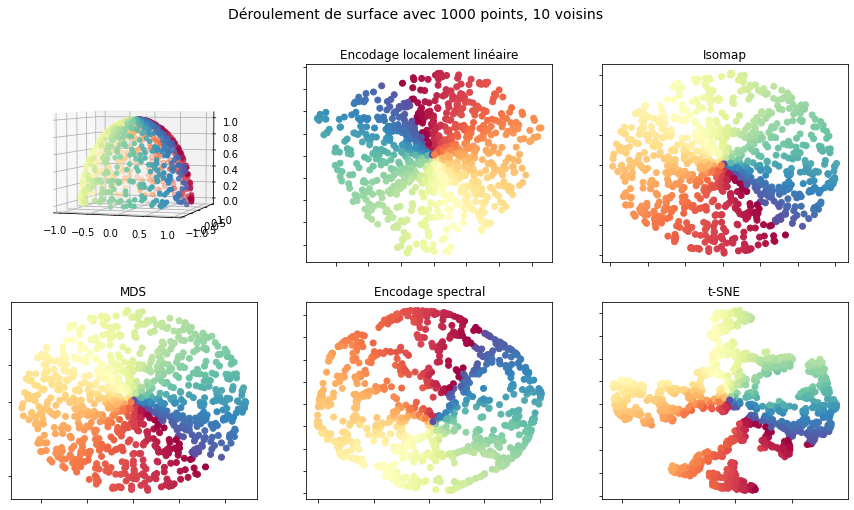

In [19]:
n_points = 1000
n_voisins = 10

# Génération d'un hémisphère
random_state = check_random_state(0)
phi = random_state.rand(n_points) * (2 * np.pi)
theta = random_state.rand(n_points) * np.pi / 2

x, y, z = np.sin(theta) * np.cos(phi), \
    np.sin(theta) * np.sin(phi), \
    np.cos(theta)

X = np.array([x, y, z]).T
couleurs = phi

DerouleSurface3D(X, couleurs, n_voisins)

#### Déroulement d'une sphère complète

Qu'obtient-on en essayant de déformer en 2D une sphère 3D complète? T-SNE la déchire et les autres méthodes 
l'écrasent comme le montrent les points superposés de différentes couleurs. Ce n'est pas possible.


C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Encodage localement linéaire: 0.2 sec
Isomap: 1.7 sec
MDS: 13 sec
Encodage spectral: 0.15 sec
t-SNE: 8.1 sec


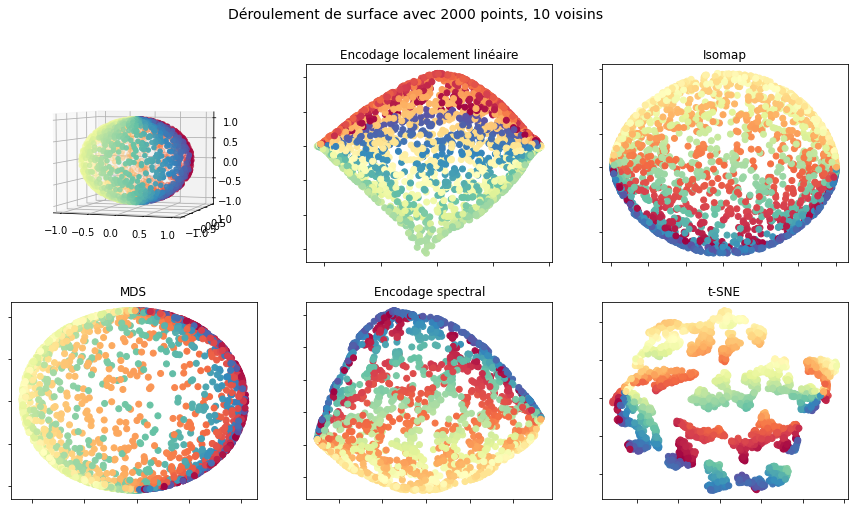

In [20]:
n_points = 2000
n_voisins = 10

# Génération d'une sphère complète
random_state = check_random_state(0)
phi = random_state.rand(n_points) * (2 * np.pi)
theta = random_state.rand(n_points) * np.pi

x, y, z = np.sin(theta) * np.cos(phi), \
    np.sin(theta) * np.sin(phi), \
    np.cos(theta)

X = np.array([x, y, z]).T
couleurs = phi


DerouleSurface3D(X, couleurs, n_voisins)

#### Déroulement d'une sphère manquant un quartier

Toutes les méthodes, sauf t-SNE qui la déchire, réussisent à déformer localement la sphère 3D afin de la déplier sur un plan. C'est un exercice de topologie facile à réaliser. Essayez d'améliorer les résultats en modifiant n_points et n_voisins.


C:\Users\Pierre Gravel\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Encodage localement linéaire: 0.46 sec
Isomap: 2.7 sec
MDS: 7.1 sec
Encodage spectral: 0.2 sec
t-SNE: 7.7 sec


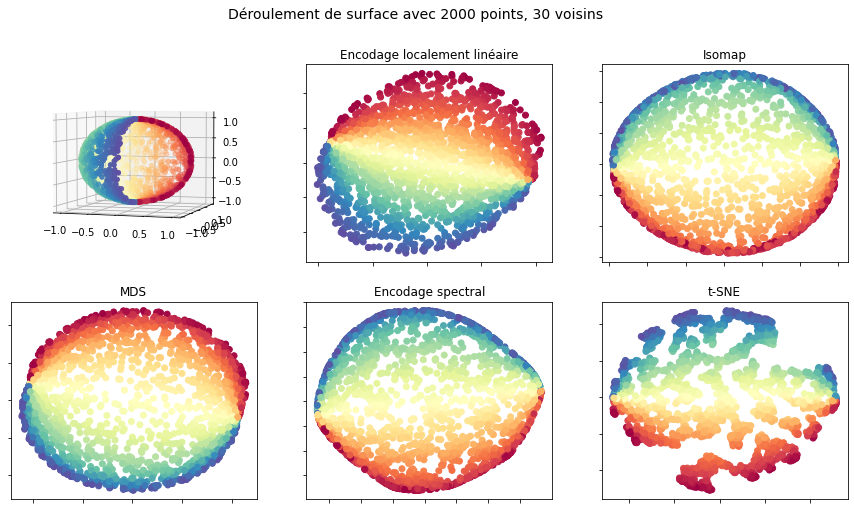

In [21]:
n_points = 2000
n_voisins = 30

# Génération d'une sphère manquant un quartier
random_state = check_random_state(0)
phi = random_state.rand(n_points) * (1.5 * np.pi)
theta = random_state.rand(n_points) * np.pi

x, y, z = np.sin(theta) * np.cos(phi), \
    np.sin(theta) * np.sin(phi), \
    np.cos(theta)

X = np.array([x, y, z]).T
couleurs = phi

DerouleSurface3D(X, couleurs, n_voisins)

Libre à vous d'explorer de nouvelles formes (non fermées) à déformer!